In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM, using both 1day Adjusted Close Parameters
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Merge
from keras.layers import Activation, Dropout
from keras.metrics import mean_squared_error

# Import fix for Tensorflow 1.0 control flow ops w/ Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_0

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close  Volume
0     0  1995-01-03  30.574097  324300
1     1  1995-01-04  30.720218  351800
2     2  1995-01-05  30.720218   89800
3     3  1995-01-06  30.751472  448400
4     4  1995-01-09  30.782794   36800
---
      Item        Date   Adj_Close     Volume
5147  5147  2015-06-12  201.460969  135382400
5148  5148  2015-06-15  200.597612  124384200
5149  5149  2015-06-16  201.691205   85308200
5150  5150  2015-06-17  202.017360  126708600
5151  5151  2015-06-18  204.118213  165867900


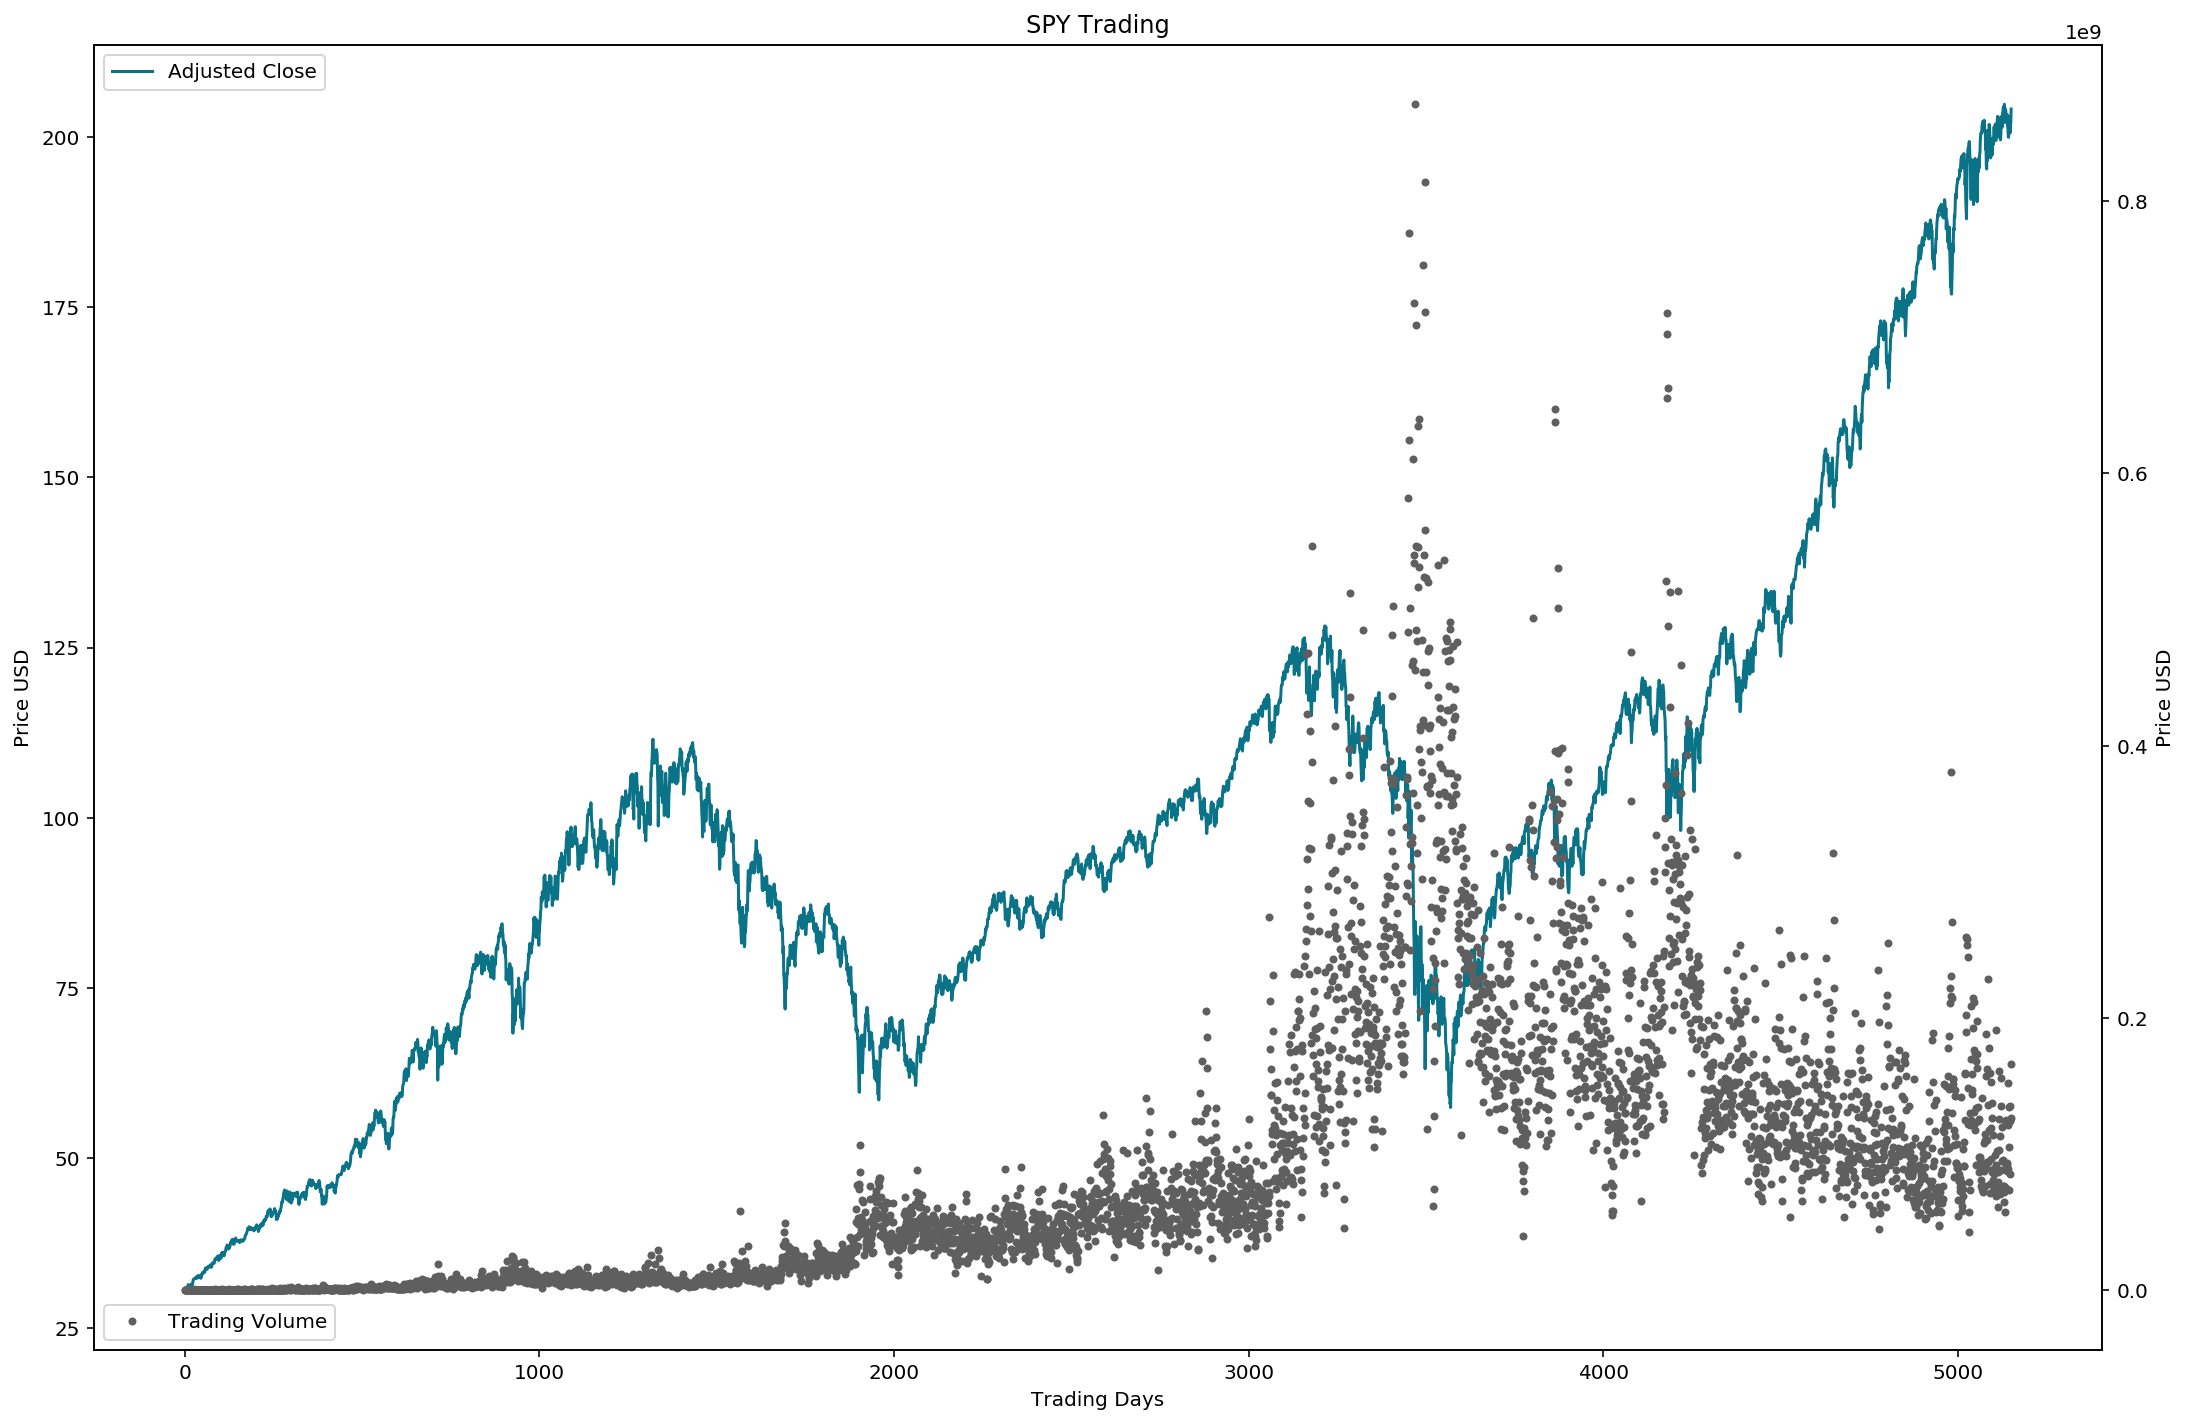

In [4]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

In [5]:
#Create numpy arrays for features and targets
day_all = []
vol_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    day_all.append([(row['Item'])])
    vol_all.append([(row['Volume'])])
    close_all.append([(row['Adj_Close'])])
    
pprint(close_all)

[[30.574097],
 [30.720218],
 [30.720218],
 [30.751471999999996],
 [30.782794],
 [30.814114],
 [30.83495],
 [30.845436],
 [31.210604999999997],
 [31.398466],
 [31.408884999999998],
 [31.377563000000002],
 [31.200188],
 [31.085387],
 [31.179352],
 [31.221090999999998],
 [31.304570000000002],
 [31.335824],
 [31.461042],
 [31.325407000000002],
 [31.450625],
 [31.440205],
 [31.628],
 [32.076716],
 [32.212351],
 [32.254090999999995],
 [32.254090999999995],
 [32.254090999999995],
 [32.29583],
 [32.306315999999995],
 [32.348056],
 [32.52543],
 [32.483691],
 [32.358473],
 [32.348056],
 [32.588006],
 [32.640232],
 [32.72371],
 [32.462788],
 [32.734127],
 [32.52543],
 [32.567170000000004],
 [32.577589],
 [32.598492],
 [32.348056],
 [32.431534],
 [32.421049],
 [32.901084999999995],
 [32.869765],
 [33.109782],
 [33.04714],
 [33.24542],
 [33.278523],
 [33.278523],
 [33.194592],
 [33.226015000000004],
 [33.247031],
 [33.719126],
 [33.855495],
 [33.855495],
 [33.845022],
 [33.782107],
 [33.645669],
 [

In [6]:
# Reshape into t and t+1
look_back = 1 
tt_split = (1.0-.315)

X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)
    
pprint(X_close_train)

array([[[ 0.        ]],

       [[ 0.00083864]],

       [[ 0.00083864]],

       ..., 
       [[ 0.26131066]],

       [[ 0.27447623]],

       [[ 0.2739438 ]]])


In [7]:
pprint(np.shape(X_close_train))
pprint(np.shape(X_close_test))

pprint(X_close_train)

pprint(y_close_train)

(3528, 1, 1)
(1622, 1, 1)
array([[[ 0.        ]],

       [[ 0.00083864]],

       [[ 0.00083864]],

       ..., 
       [[ 0.26131066]],

       [[ 0.27447623]],

       [[ 0.2739438 ]]])
array([[ 0.        ],
       [ 0.00083864],
       [ 0.00083864],
       ..., 
       [ 0.26131066],
       [ 0.27447623],
       [ 0.2739438 ]])


In [8]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Set up hyperparameters
batch_size = 1
epochs = 5 # 200
n_nodes = [128]

# Create two branches of LSTM model

# Create LSTM Adjusted Close network - 1 day tracker 
model = Sequential()
model.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
print 'compilation time : ', time.time() - start

compilation time :  0.151164054871


In [9]:
# Format inputs
train_inputs = X_close_train

# Train the model
model.fit(train_inputs, 
                y_close_train, 
                nb_epoch=epochs, 
                batch_size=batch_size, 
                verbose=2
                #validation_split=0.05
                )

Epoch 1/5
11s - loss: 0.0013
Epoch 2/5
11s - loss: 9.5719e-07
Epoch 3/5
12s - loss: 2.7925e-06
Epoch 4/5
11s - loss: 8.0101e-07
Epoch 5/5
12s - loss: 2.3723e-06


In [10]:
# Format inputs
test_inputs = X_close_test

# Generate predictions for training
#testPredict = model.predict(test_inputs, batch_size=batch_size)
testPredict = util.predict_sequences(model, test_inputs)

pprint(testPredict)

[[0.2783581],
 [0.26477221],
 [0.26656741],
 [0.25710714],
 [0.24672665],
 [0.24750273],
 [0.23421457],
 [0.23436002],
 [0.23756059],
 [0.21579157],
 [0.23266289],
 [0.22635968],
 [0.22810511],
 [0.23086876],
 [0.23499046],
 [0.24886087],
 [0.23508747],
 [0.2267475],
 [0.22553547],
 [0.23115972],
 [0.2291718],
 [0.23518445],
 [0.24687228],
 [0.24745421],
 [0.22810511],
 [0.23048092],
 [0.23077184],
 [0.22640818],
 [0.20924838],
 [0.20832759],
 [0.20420842],
 [0.20052576],
 [0.18710652],
 [0.2008165],
 [0.19786096],
 [0.19180518],
 [0.18361929],
 [0.16749558],
 [0.16493014],
 [0.17296615],
 [0.15878353],
 [0.15936422],
 [0.15544449],
 [0.1750965],
 [0.1773722],
 [0.19122383],
 [0.19408199],
 [0.19296776],
 [0.20420842],
 [0.21268943],
 [0.20789139],
 [0.19974591],
 [0.22664325],
 [0.2187334],
 [0.22288348],
 [0.23098931],
 [0.22366466],
 [0.20989753],
 [0.21346097],
 [0.22097929],
 [0.23255208],
 [0.23660566],
 [0.2333823],
 [0.22386003],
 [0.22815704],
 [0.24417646],
 [0.2442742],
 [0.

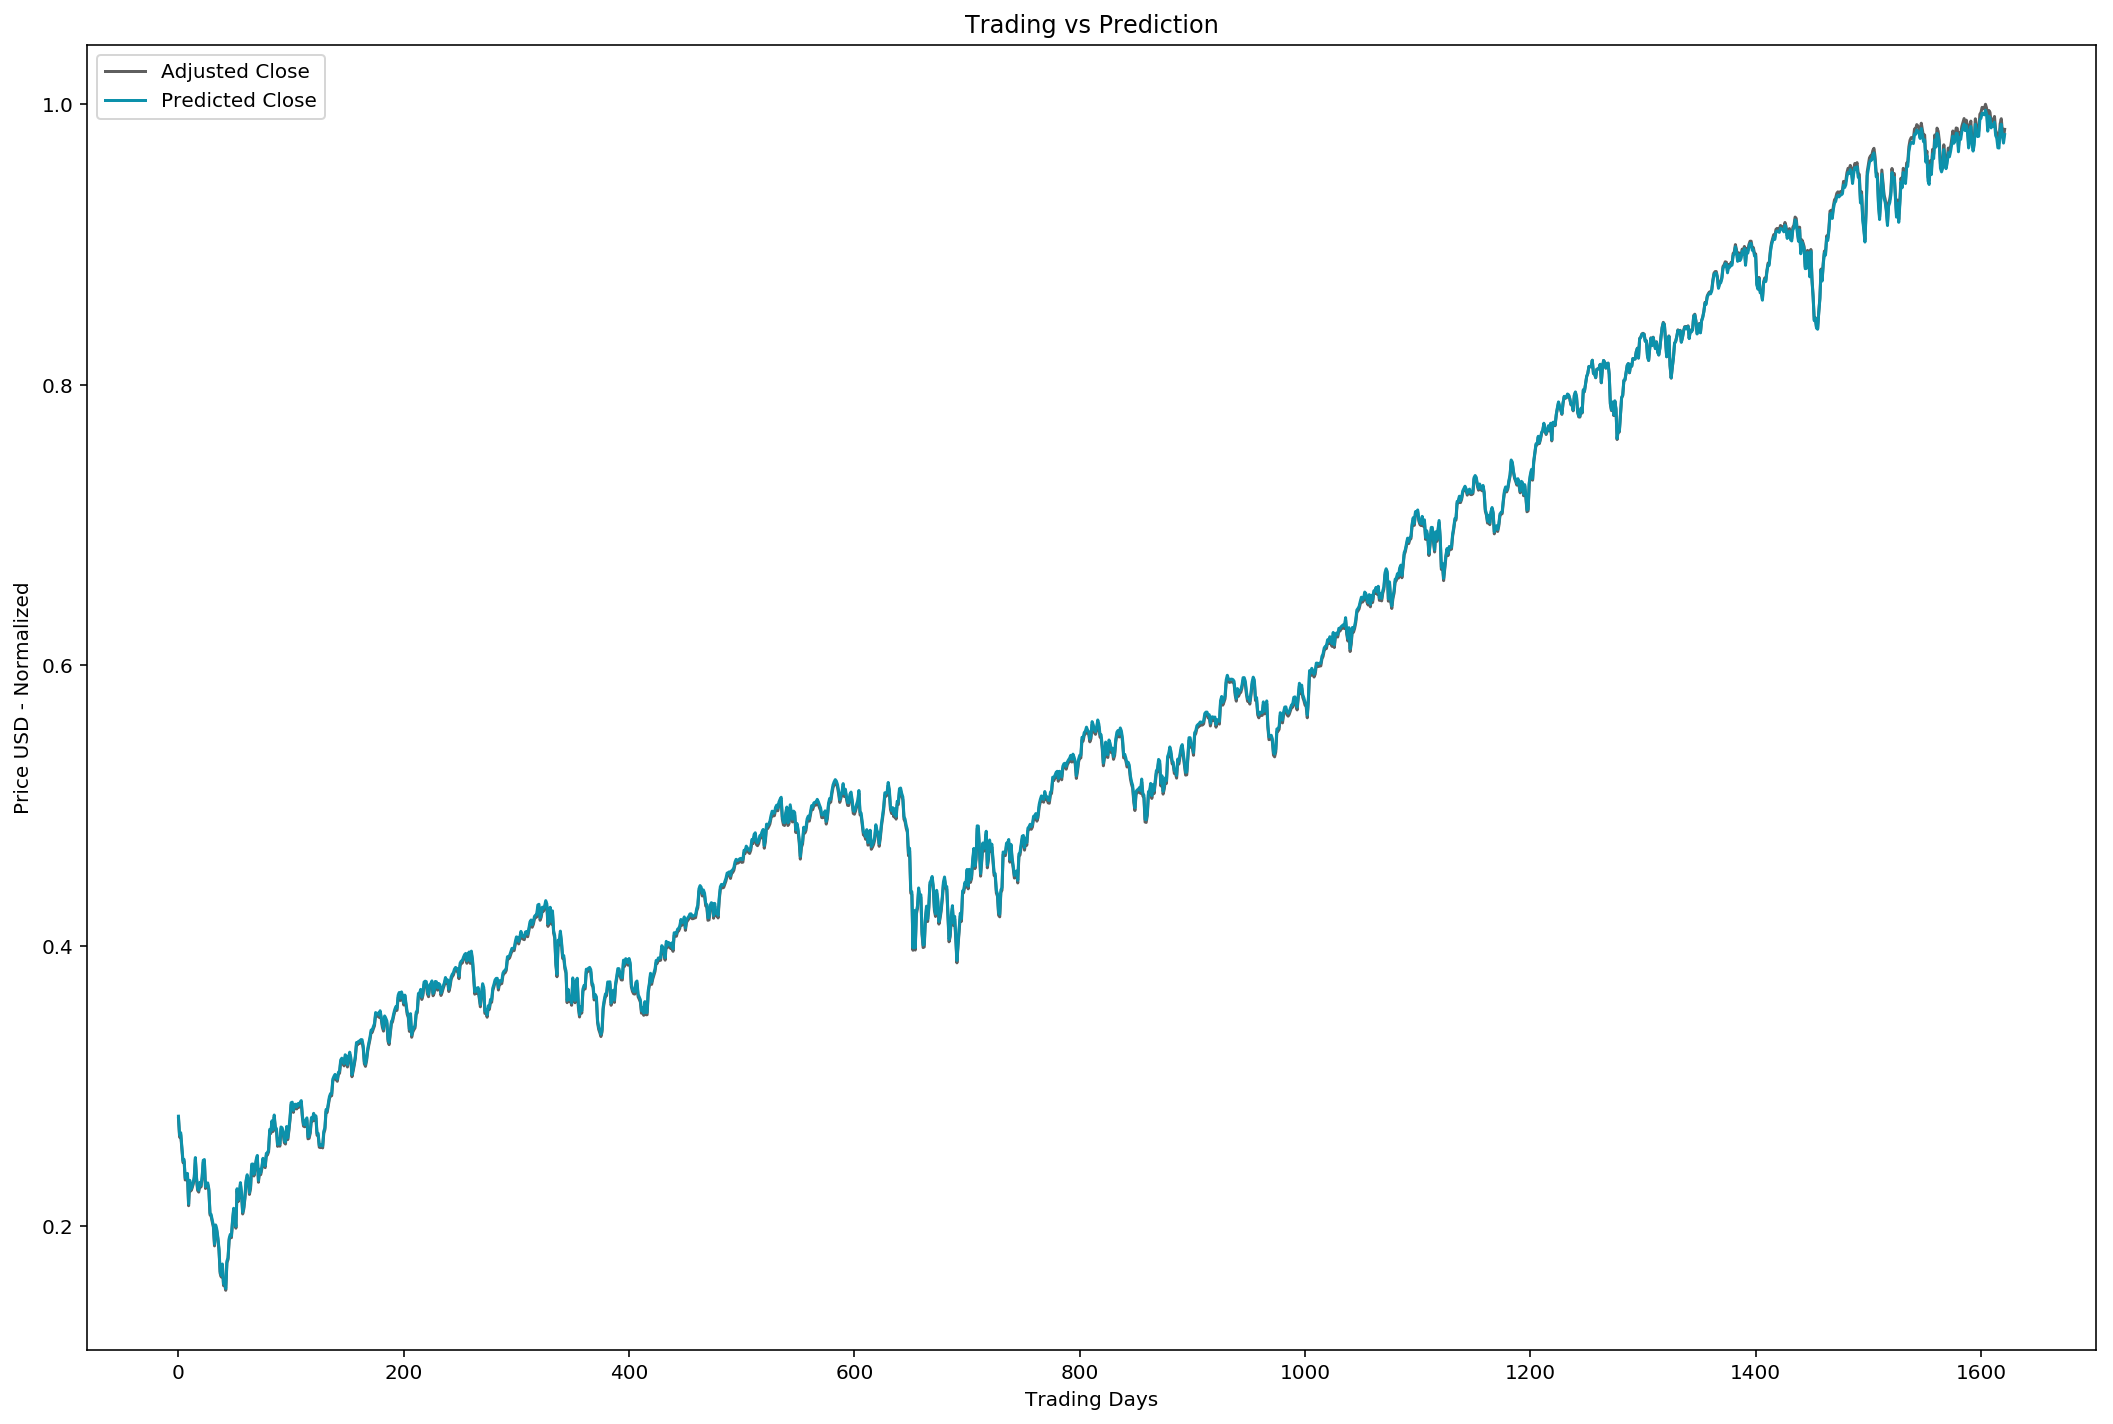

In [11]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [12]:
# The mean squared error
testScore = model.evaluate(test_inputs, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

# Calculate the stock price delta in $
true_delta = testScore*(close_bounds[1]-close_bounds[0])
print('Delta Price: %.6f - RMSE * Adjusted Close Range' % true_delta)

Test Score: 0.000003 MSE (0.001834 RMSE)
Delta Price: 0.000586 - RMSE * Adjusted Close Range


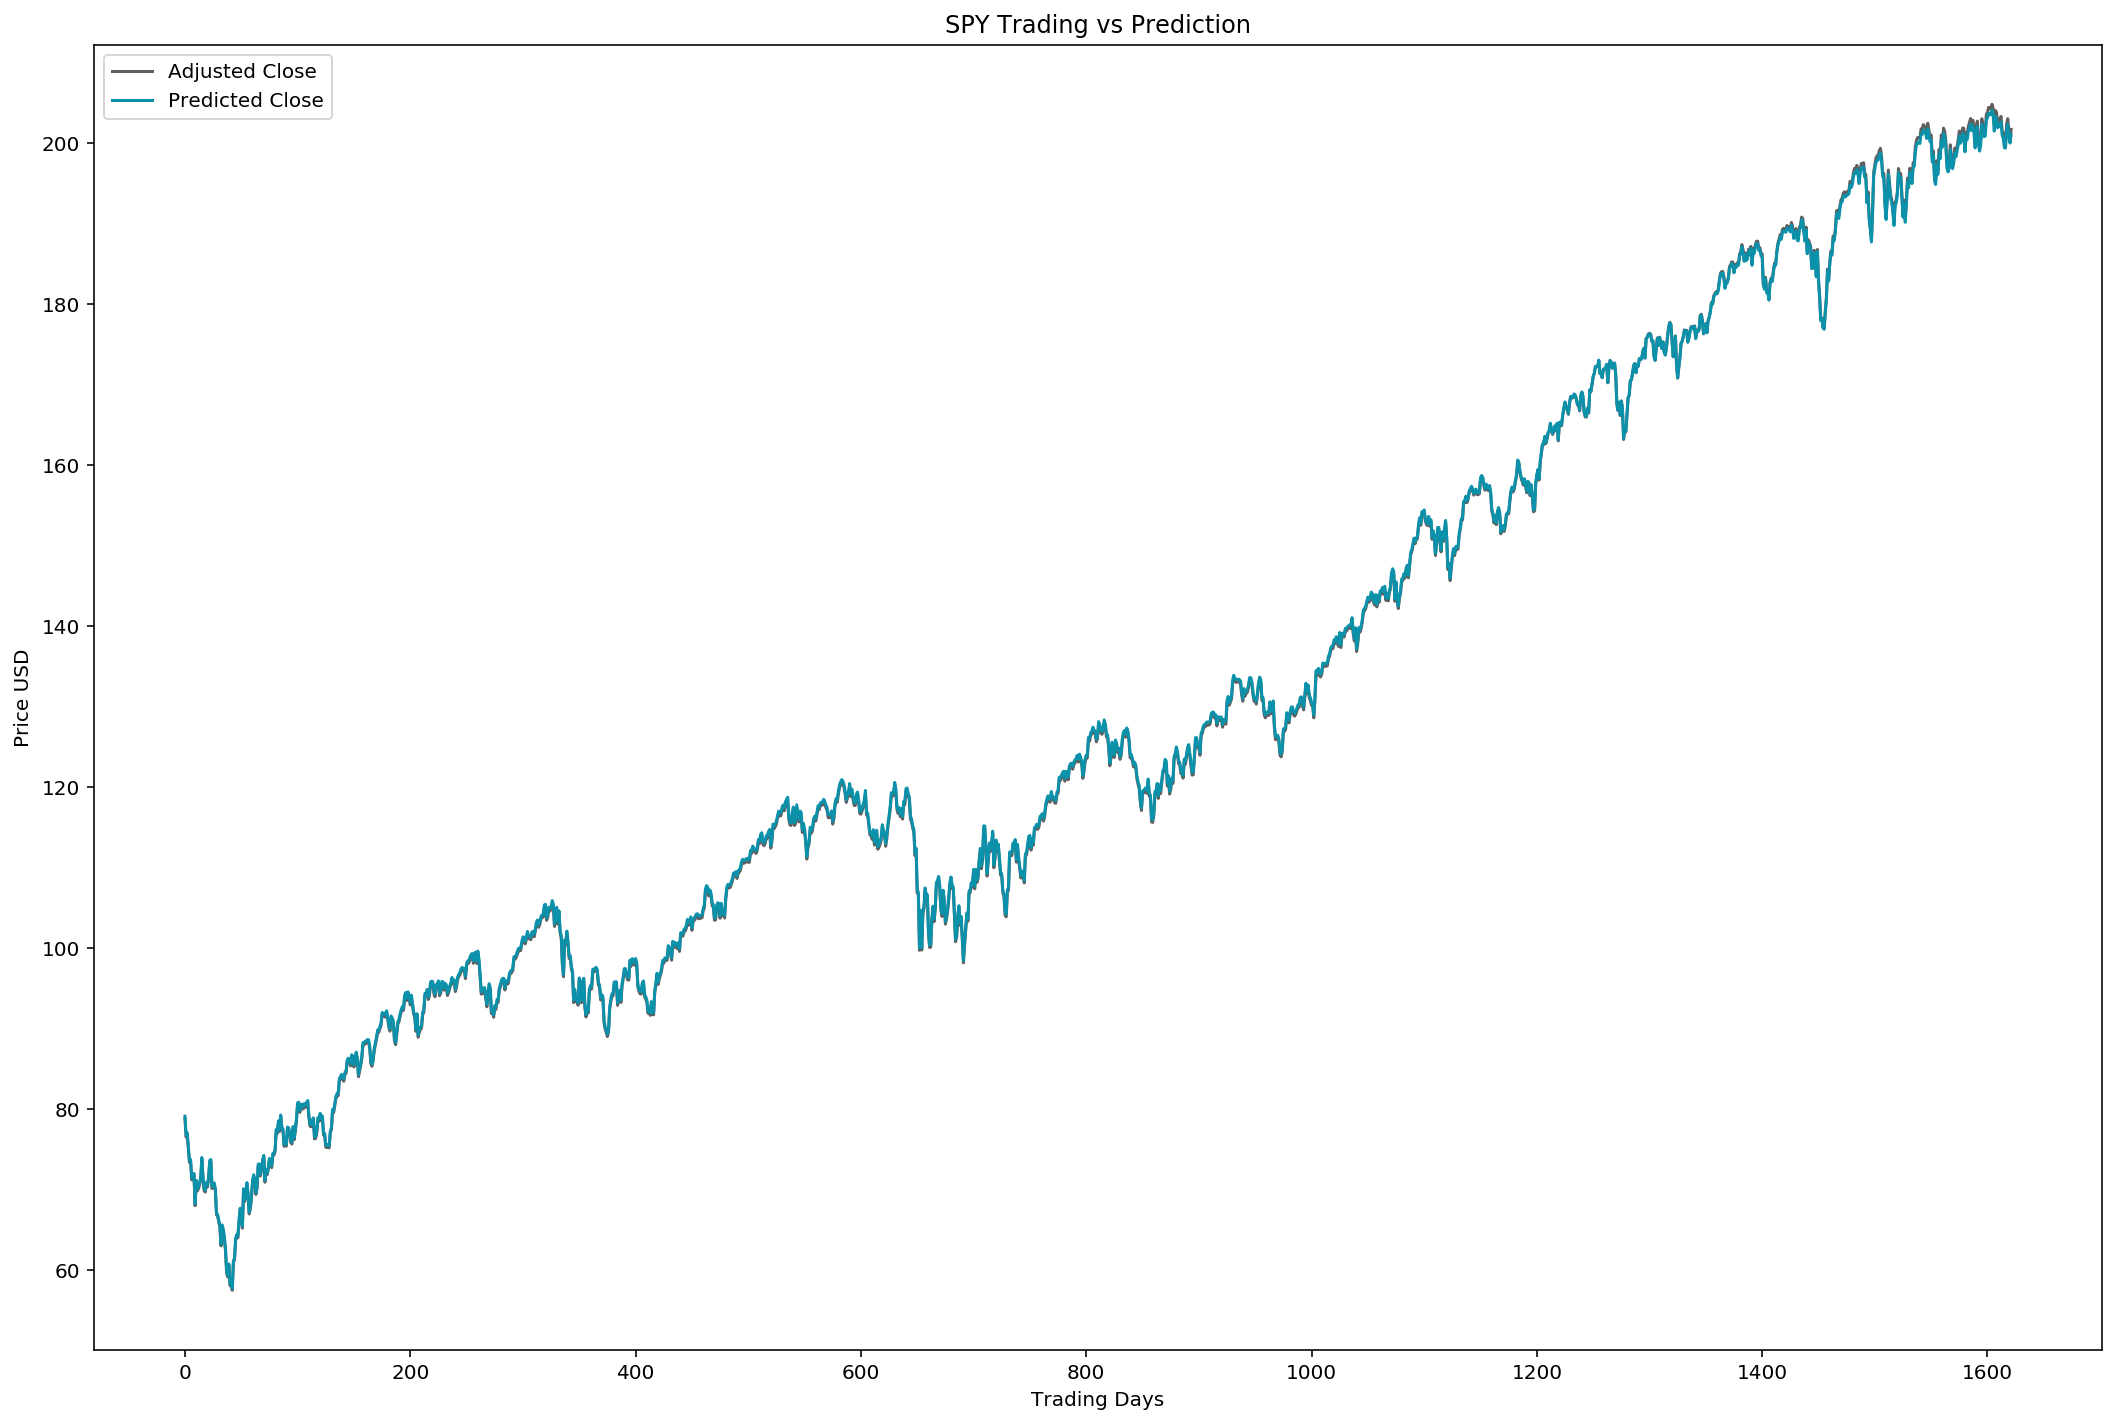

In [13]:
# Plot the predictions
#close_plot = close_all[-ya_close_test.shape[0]:]

close_seq = np.array(y_close_test)
pred_seq = np.array(testPredict)

#pprint(pred_seq)
close_seq_plot, r = util.scale_range(y_close_test, input_range=[0.0,1.0], target_range=close_bounds)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_seq_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

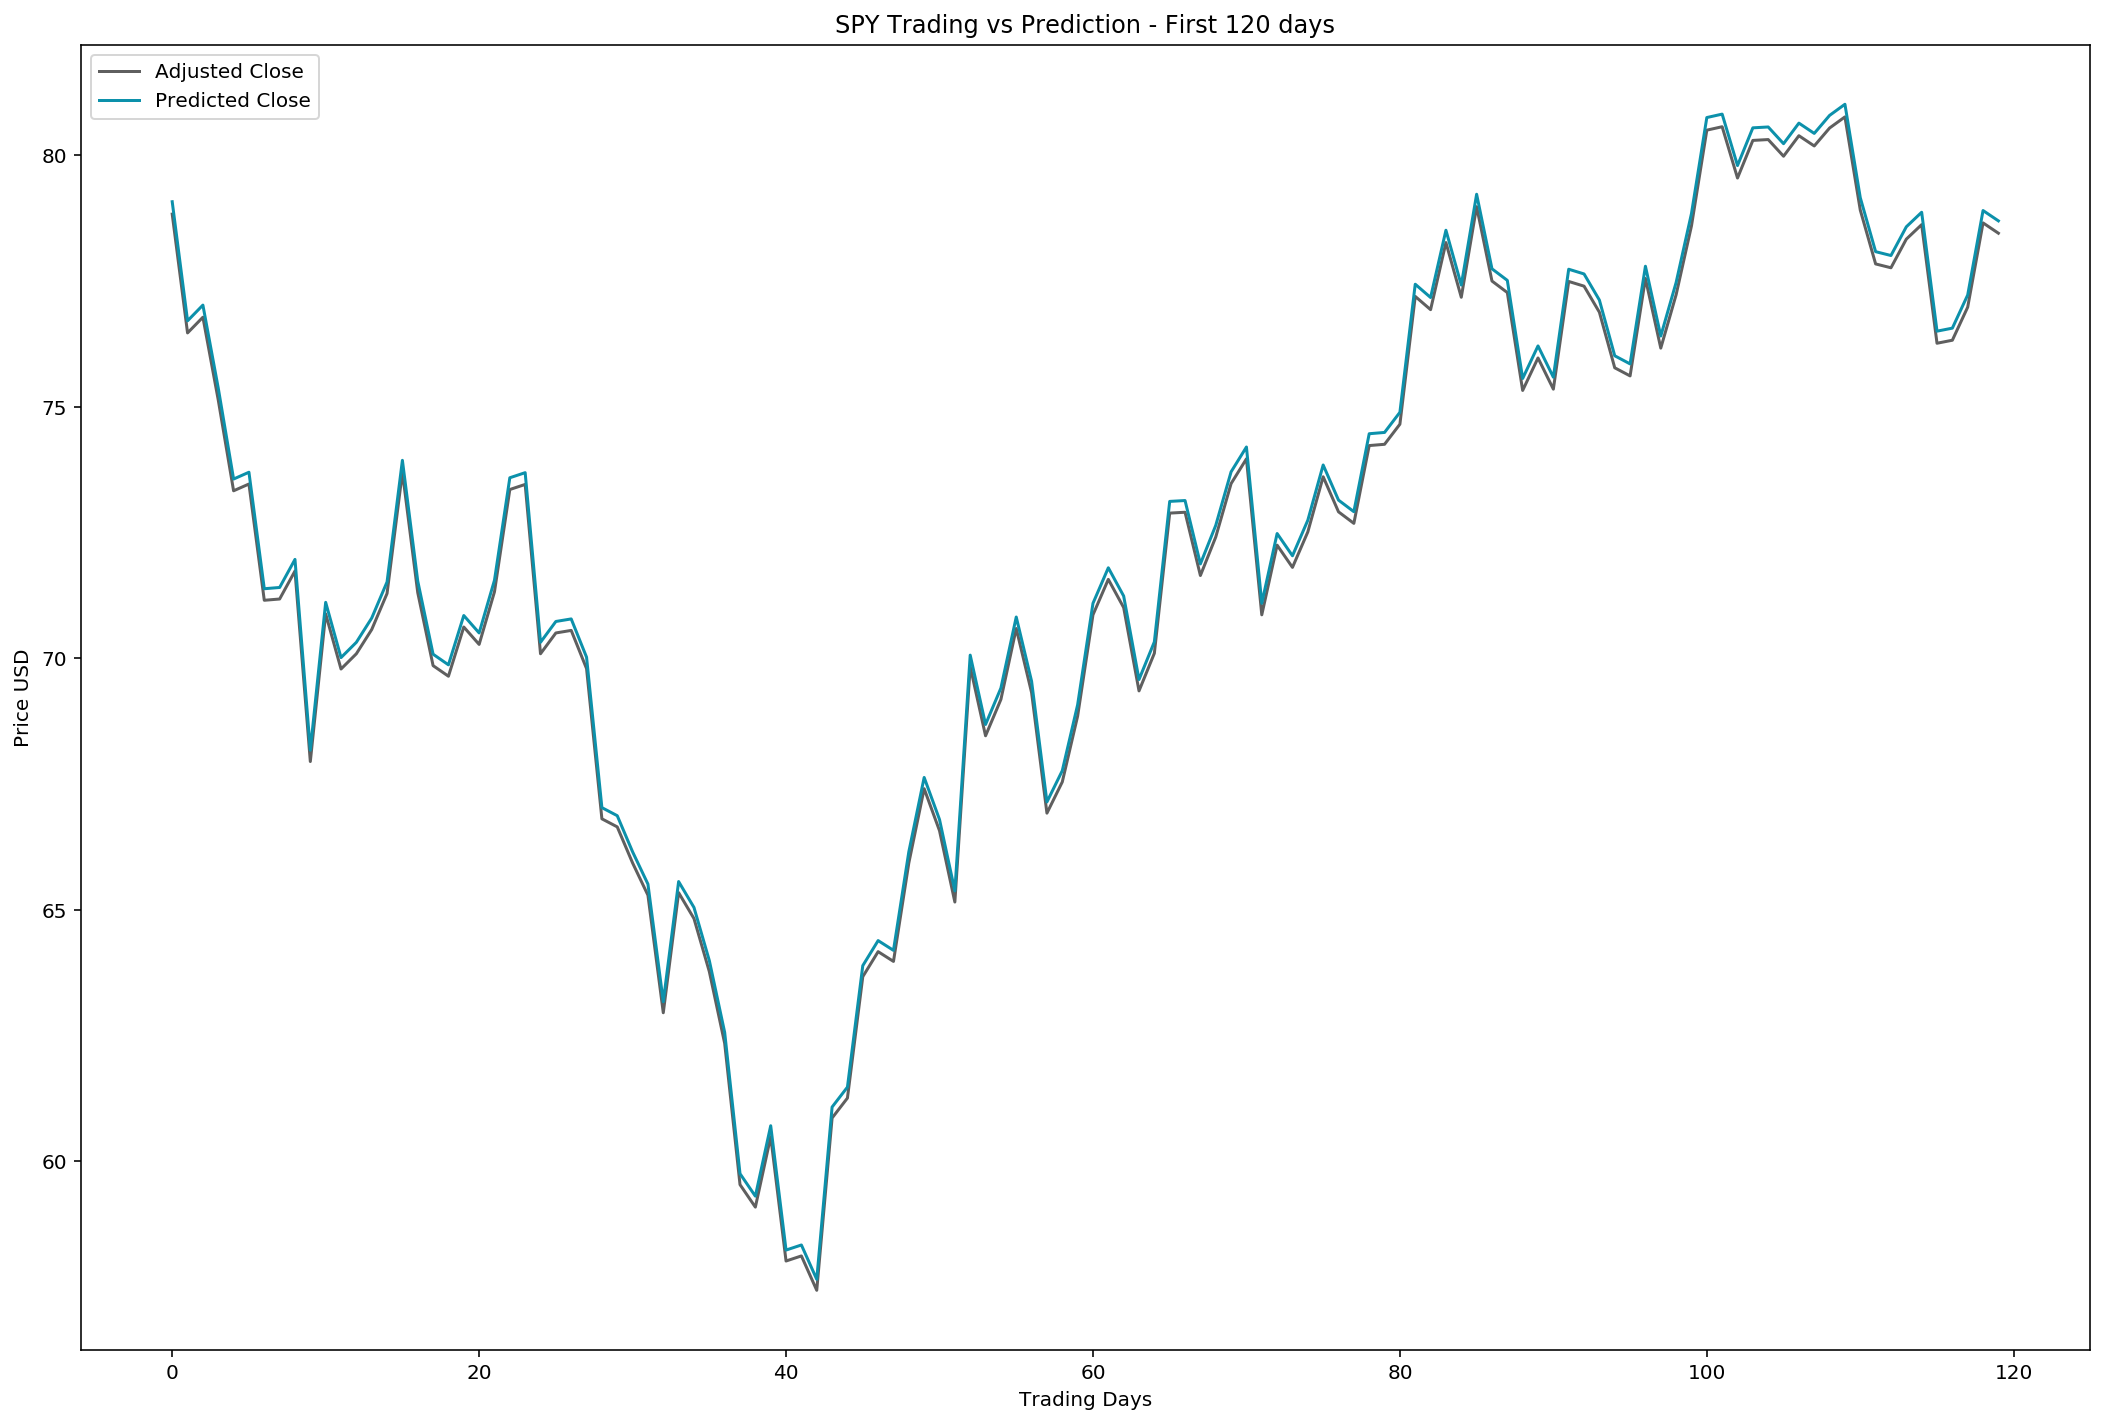

In [14]:
# Plot the predictions first 120 days (6 months of trading)
subspan = 120
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_seq_plot[:subspan],'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot[:subspan], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction - First 120 days')
ax.legend(loc='upper left')

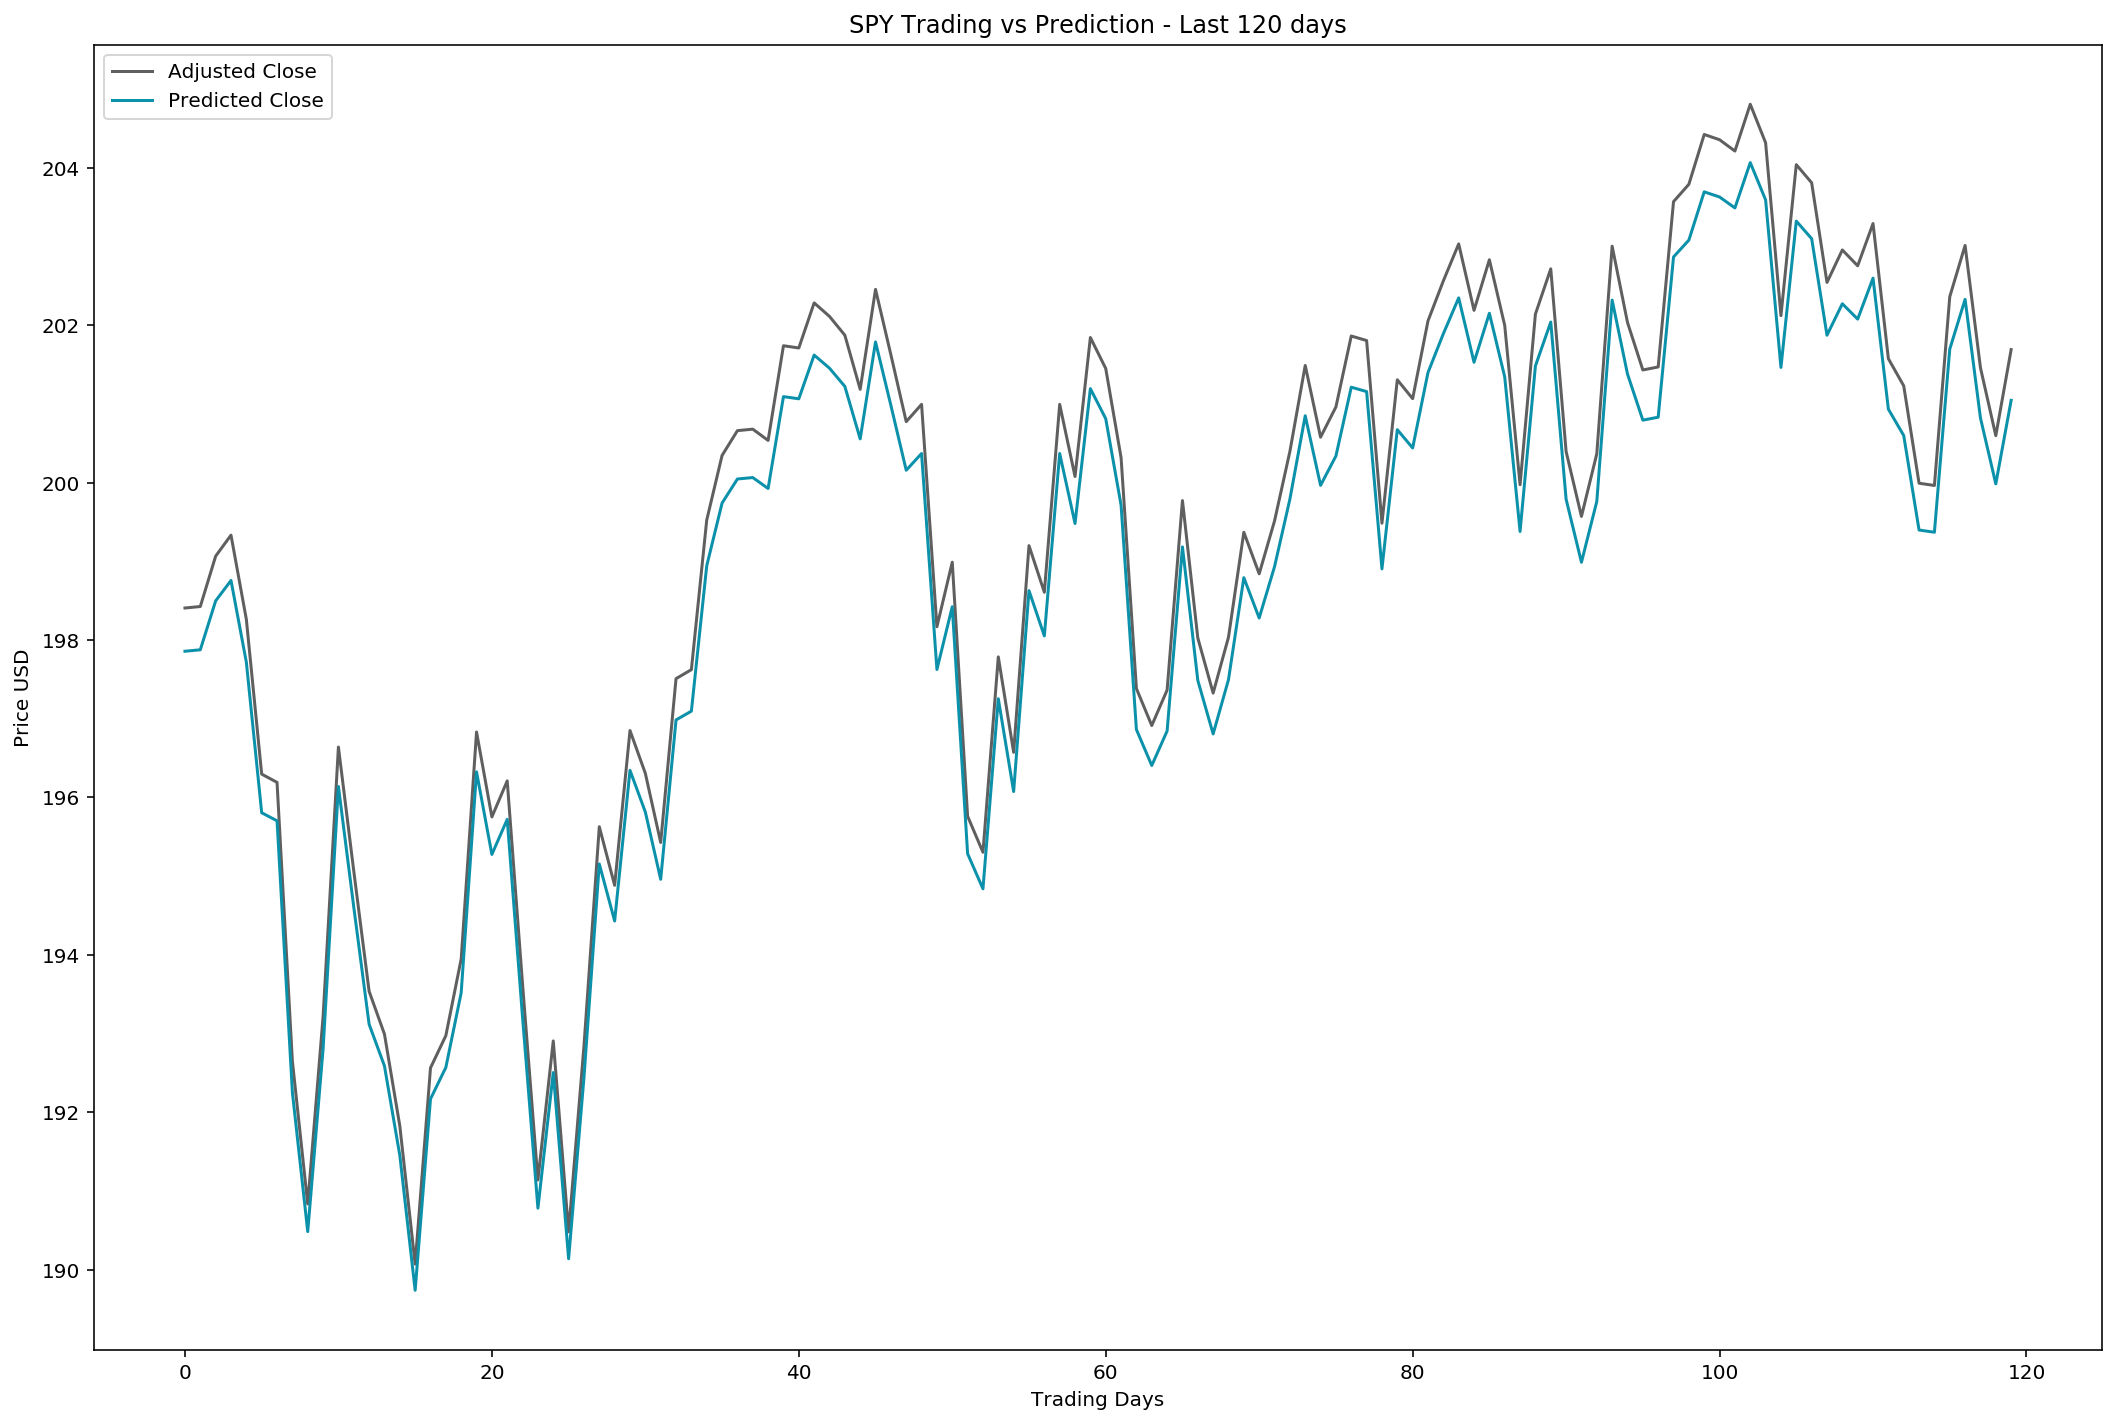

In [15]:
# Plot the predictions last 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_seq_plot[-subspan:],'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot[-subspan:], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction - Last 120 days')
ax.legend(loc='upper left')

In [16]:
# Trading Algorithm

# Create a dataframe for stock data
trades_df = pd.DataFrame(columns=('Price','Prediction','PredDelta','State','Shares','IncShares','StockValue','Cash','Folio','IncSum','Performance'))
# Create variable for stock ownership
own = True

# Loop through trading days
for i in range(0, len(preds_seq_plot)):
    # Until the final day in sequence
    if i < len(preds_seq_plot)-1:
        # For first day, initiate trading
        if i == 0:
            start_price = close_seq_plot[0][0]
            trades_df.loc[i,'Price'] = start_price
            trades_df.loc[i,'Folio'] = 1000.0
            trades_df.loc[i,'State'] = 'Buy'
            trades_df.loc[i,'Shares'] = math.floor(trades_df.loc[i,'Folio']/start_price)
            trades_df.loc[i,'StockValue'] = trades_df.loc[i,'Shares']*start_price
            trades_df.loc[i,'Cash'] = trades_df.loc[i,'Folio']-trades_df.loc[i,'StockValue'] 
            trades_df.loc[i,'PredDelta'] = 0.0
            trades_df.loc[i,'IncSum'] = start_price
            trades_df.loc[i,'IncShares'] = trades_df.loc[i,'Shares']
            buy_price = start_price
            own = True
        # Otherwise, it's the end of the trading day and we decide on trade executed just after close
        else:
            # Get yesterday's closing price
            price_yest = close_seq_plot[i-1][0]
            # Get today's closing price
            price_today = close_seq_plot[i][0]
            
            # quick calc for sum of increase
            if price_today>price_yest:
                trades_df.loc[i,'IncSum'] = trades_df.loc[i-1,'IncSum']+price_today-price_yest
            else:
                trades_df.loc[i,'IncSum'] = trades_df.loc[i-1,'IncSum']
            
            # Get todays's prediction
            pred_today = preds_seq_plot[i][0]
            # Get tomorrow's prediction
            pred_tomorrow = preds_seq_plot[i+1][0]
            # Get delta price
            pred_delta = pred_tomorrow-pred_today
            # Store the price
            trades_df.loc[i,'Price'] = price_today
            # Store the prediction
            trades_df.loc[i,'Prediction'] = pred_tomorrow
            # Store prediction delta
            trades_df.loc[i,'PredDelta'] = pred_delta

            # If the stock is currently owned
            if own == True:    
                # If the projection is positive
                if pred_delta > 0:
                    # Hold the stock
                    trades_df.loc[i,'State'] = 'Hold'
                    trades_df.loc[i,'Shares'] = trades_df.loc[i-1,'Shares']
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']
                    own = True
                else:
                    # Sell the stock
                    trades_df.loc[i,'State'] = 'Sell'
                    trades_df.loc[i,'Shares'] = 0.0
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']+trades_df.loc[i-1,'Shares']*price_today
                    own = False
            # If the stock is not owned
            else:
                # If the projection is positive
                if pred_delta > 0:
                    # Buy the stock
                    trades_df.loc[i,'State'] = 'Buy'
                    # Store number of shares (cash/currentprice)
                    trades_df.loc[i,'Shares'] = math.floor(trades_df.loc[i-1,'Cash']/price_today)
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']-(trades_df.loc[i,'Shares']*price_today)
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i,'Shares']
                    own = True
                else:
                    # Set the state to pass on trading
                    trades_df.loc[i,'State'] = 'Pass'
                    # Update the number of shares to yesterdays
                    trades_df.loc[i,'Shares'] = 0.0
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']
                    own = False
            # Update Folio and Stock Value
            trades_df.loc[i,'StockValue'] = trades_df.loc[i,'Shares']*price_today
            trades_df.loc[i,'Folio'] =trades_df.loc[i,'StockValue']+trades_df.loc[i,'Cash']

    else:
        # Update last day since there aren't any more predictions
        trades_df.loc[i,'Price'] = close_seq_plot[i][0]
        trades_df.loc[i,'Folio'] = trades_df.loc[i-1,'Folio']
        trades_df.loc[i,'Shares'] = trades_df.loc[i-1,'Shares']
        trades_df.loc[i,'StockValue'] = trades_df.loc[i,'Price']*trades_df.loc[i,'Shares']
        trades_df.loc[i,'State'] = trades_df.loc[i-1,'State']
        trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
        trades_df.loc[i,'IncSum'] = trades_df.loc[i-1,'IncSum']
        trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']

trades_df['Performance'] = trades_df.loc[:,'Folio']/trades_df.loc[0,'Folio']
trades_df['NoLossMarketValue']=trades_df.loc[:,'IncSum']*trades_df.loc[0,'Shares']+trades_df.loc[0,'Cash']
trades_df['NoLossMarketPerform']=trades_df.loc[:,'NoLossMarketValue']/trades_df.loc[0,'NoLossMarketValue']
trades_df['MarketOpt']=trades_df.loc[:,'IncShares']*trades_df.loc[:,'IncSum']+trades_df.loc[0,'Cash']
trades_df['MarketOptPerform']=trades_df.loc[:,'MarketOpt']/trades_df.loc[0,'MarketOpt']
trades_df['InactiveValue']=trades_df.loc[0,'IncShares']*trades_df['Price']+trades_df.loc[0,'Cash']
trades_df['InactivePerform']=trades_df.loc[:,'InactiveValue']/trades_df.loc[0,'InactiveValue']

#close_seq_plot
#preds_seq_plot

pprint(trades_df)
trades_df.to_csv('logs/Study12-'+base_ticker+'.csv')

        Price Prediction  PredDelta State Shares IncShares StockValue  \
0     78.8275        NaN          0   Buy     12        12     945.93   
1     76.4661    77.0194   0.312782  Hold     12        12    917.594   
2     76.7782    75.3711   -1.64831  Sell      0        12          0   
3     75.1337    73.5625   -1.80864  Pass      0        12          0   
4     73.3289    73.6977   0.135216   Buy     13        13    953.276   
5     73.4638    71.3824   -2.31525  Sell      0        13          0   
6     71.1531    71.4078  0.0253372   Buy     13        13     924.99   
7     71.1784    71.9654   0.557655  Hold     13        13    925.319   
8      71.735    68.1725   -3.79292  Sell      0        13          0   
9     67.9484    71.1121    2.93957   Buy     14        14    951.277   
10    70.8832    70.0138   -1.09824  Sell      0        14          0   
11    69.7869    70.3179   0.304115   Buy     14        14    977.016   
12    70.0905    70.7995   0.481522  Hold     14   

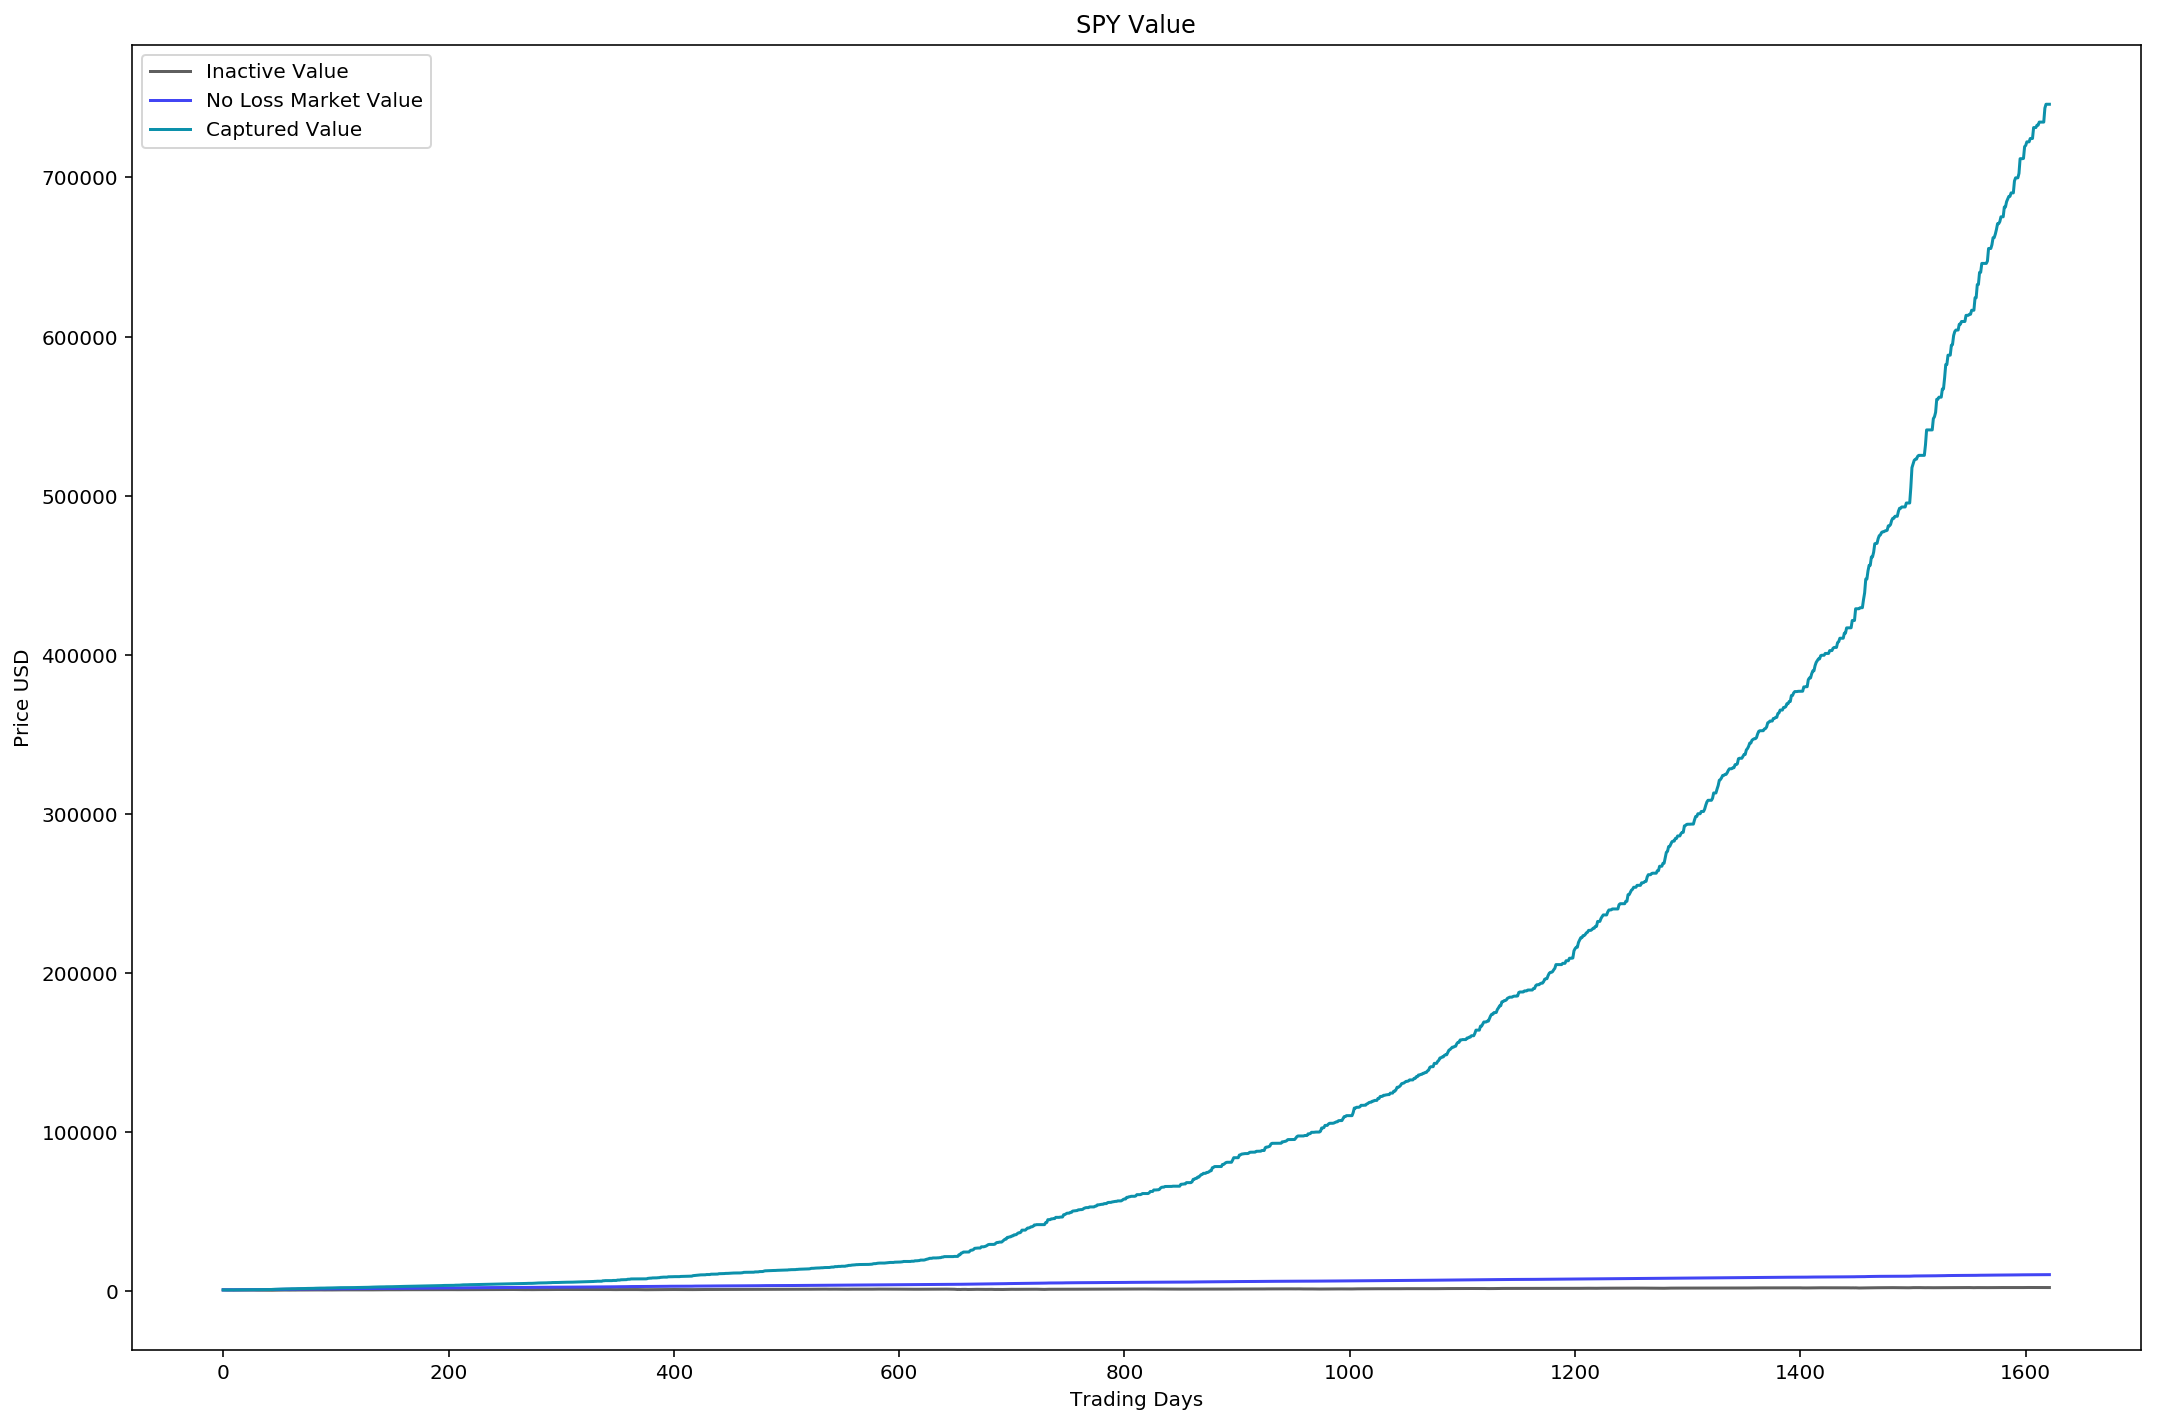

In [17]:
# Plot the stock price and captured value 

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[:,'InactiveValue'],'#5F5F5F', label='Inactive Value')
plt.plot(trades_df.loc[:,'NoLossMarketValue'], '#4245f4', label='No Loss Market Value')
#plt.plot(trades_df.loc[:,'MarketOpt'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[:,'Folio'], '#0C91AB', label='Captured Value')

# Set title
ax.set_title(base_ticker + ' Value')
ax.legend(loc='upper left')

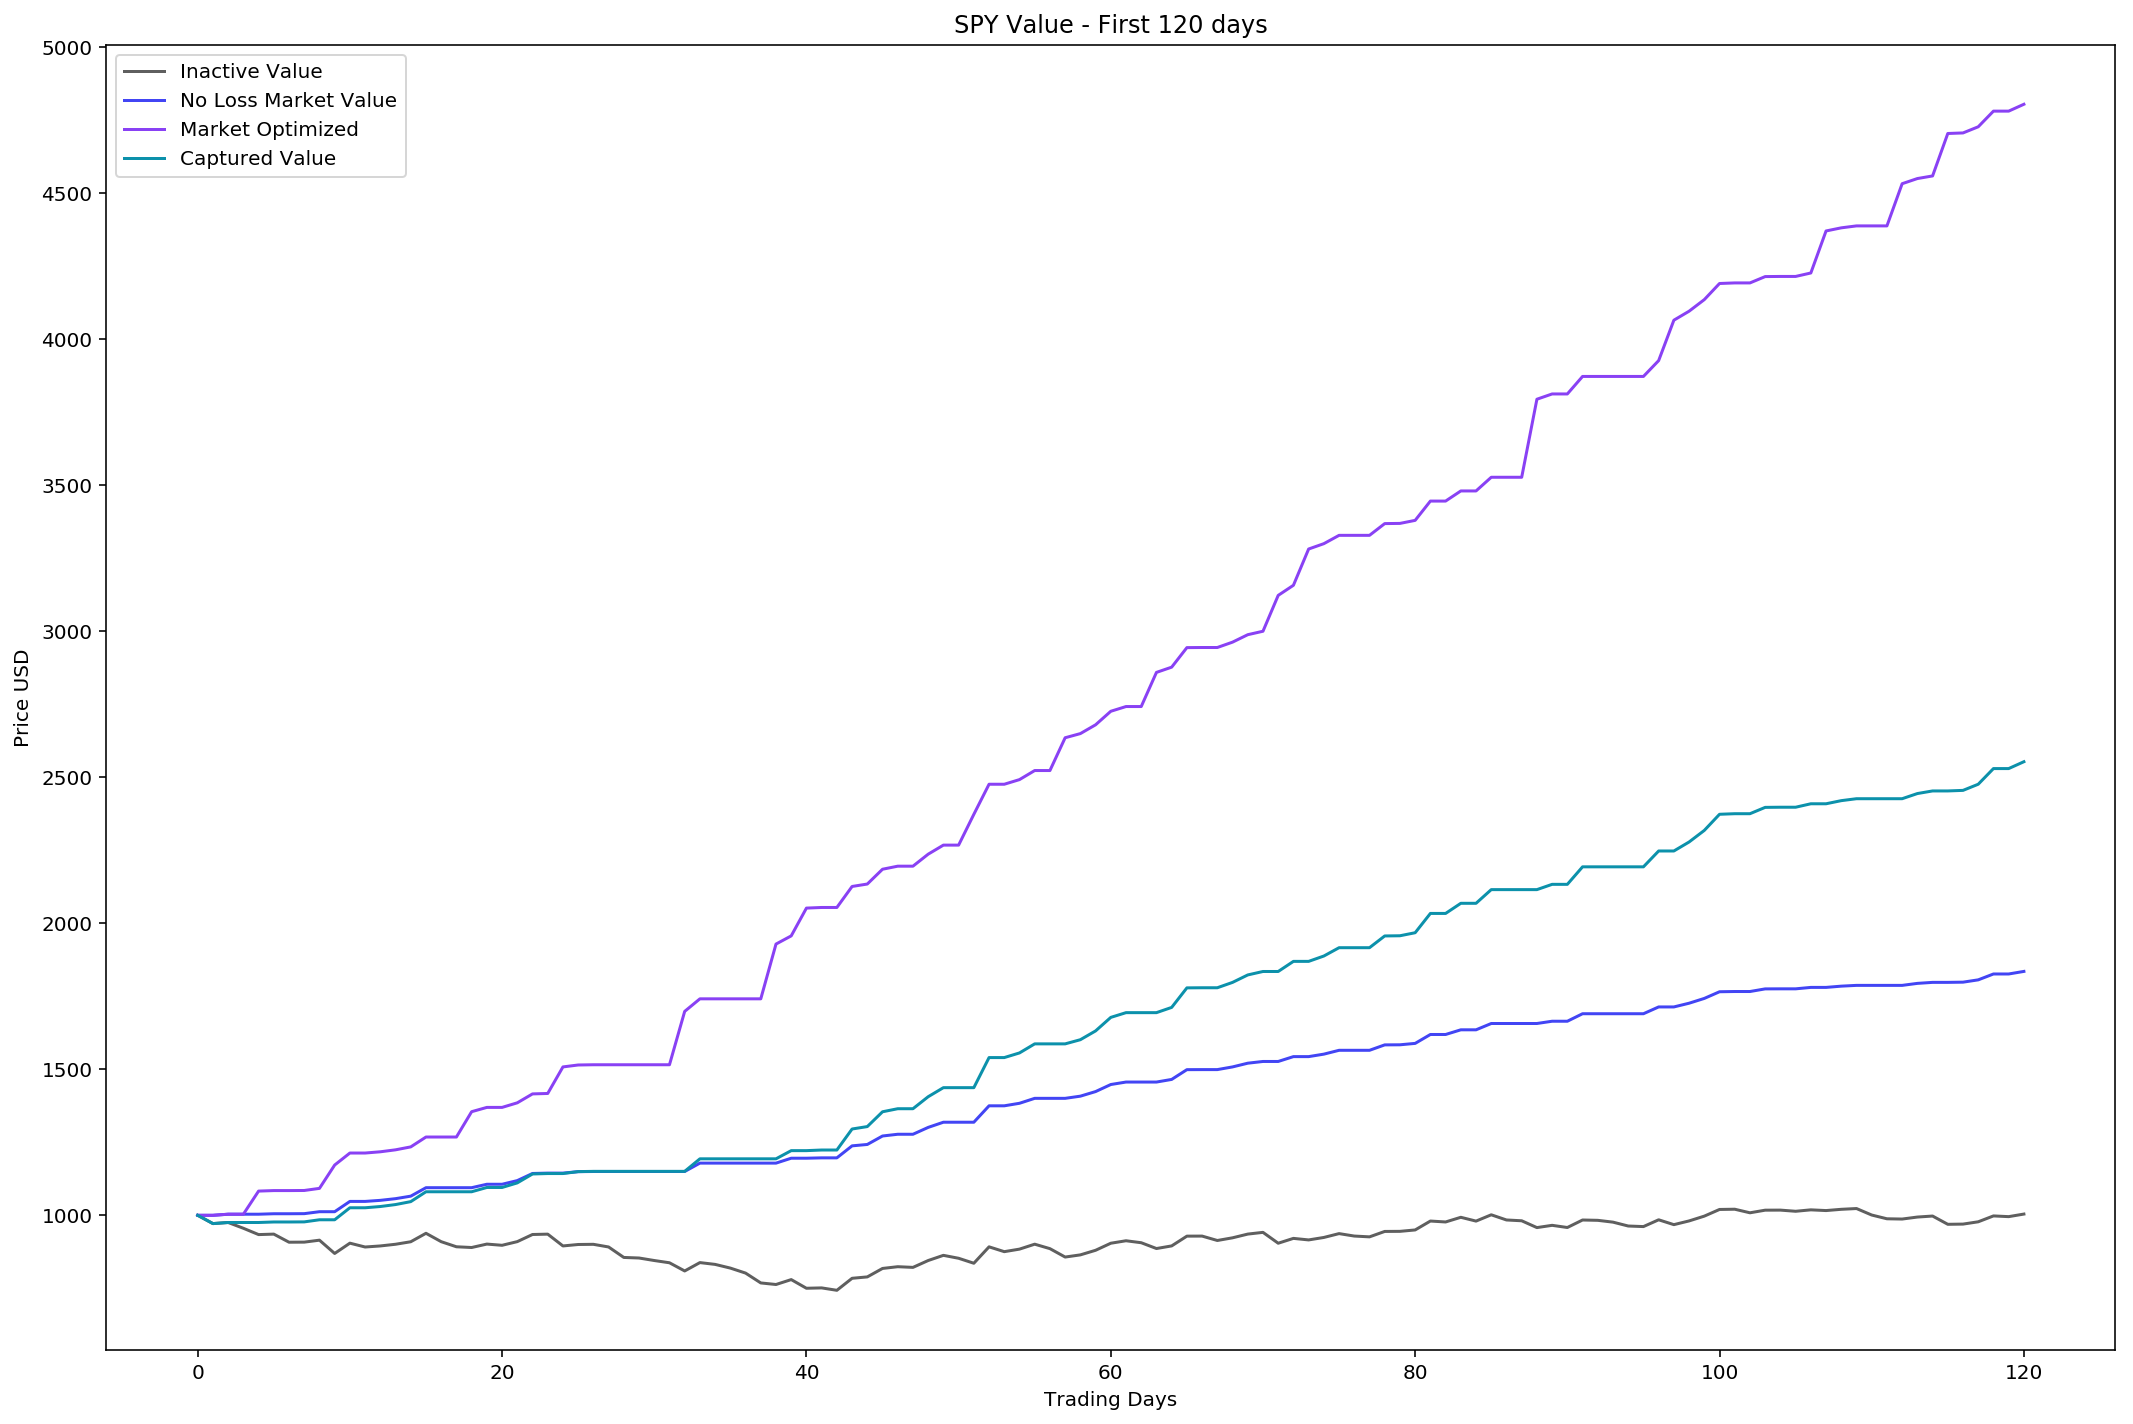

In [18]:
# Plot the stock price and captured value first 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[:120,'InactiveValue'],'#5F5F5F', label='Inactive Value')
plt.plot(trades_df.loc[:120,'NoLossMarketValue'], '#4245f4', label='No Loss Market Value')
plt.plot(trades_df.loc[:120,'MarketOpt'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[:120,'Folio'], '#0C91AB', label='Captured Value')

# Set title
ax.set_title(base_ticker + ' Value - First 120 days')
ax.legend(loc='upper left')

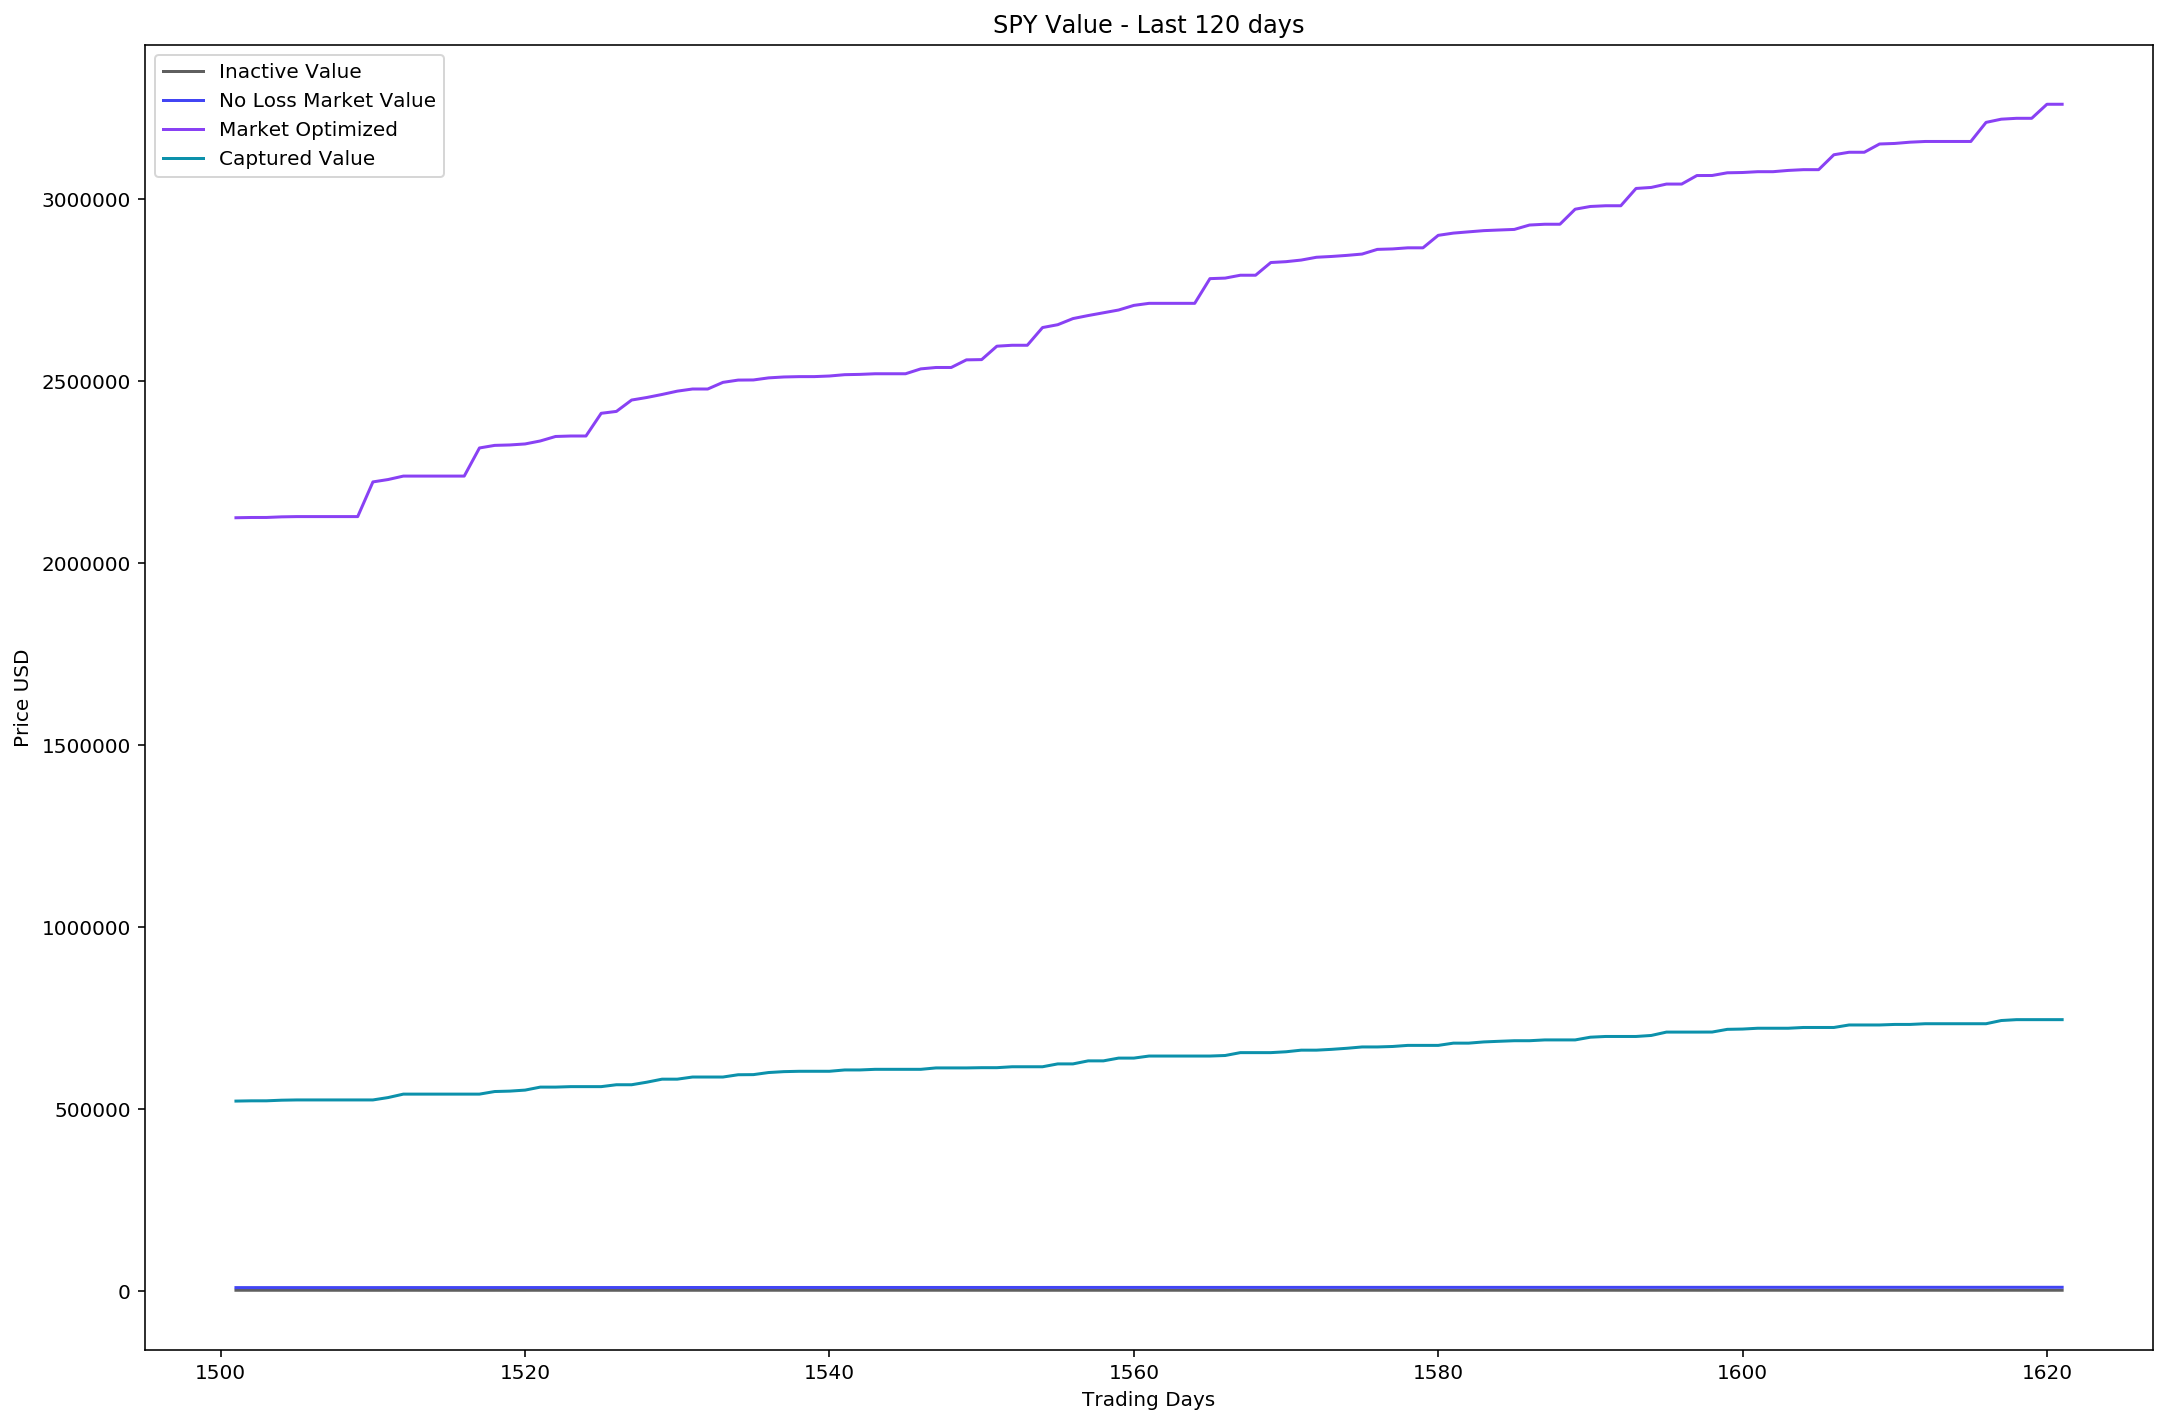

In [19]:
# Plot the stock price and captured value last 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[1621-120:,'InactiveValue'],'#5F5F5F', label='Inactive Value')
plt.plot(trades_df.loc[1621-120:,'NoLossMarketValue'], '#4245f4', label='No Loss Market Value')
plt.plot(trades_df.loc[1621-120:,'MarketOpt'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[1621-120:,'Folio'], '#0C91AB', label='Captured Value')

# Set title
ax.set_title(base_ticker + ' Value - Last 120 days')
ax.legend(loc='upper left')

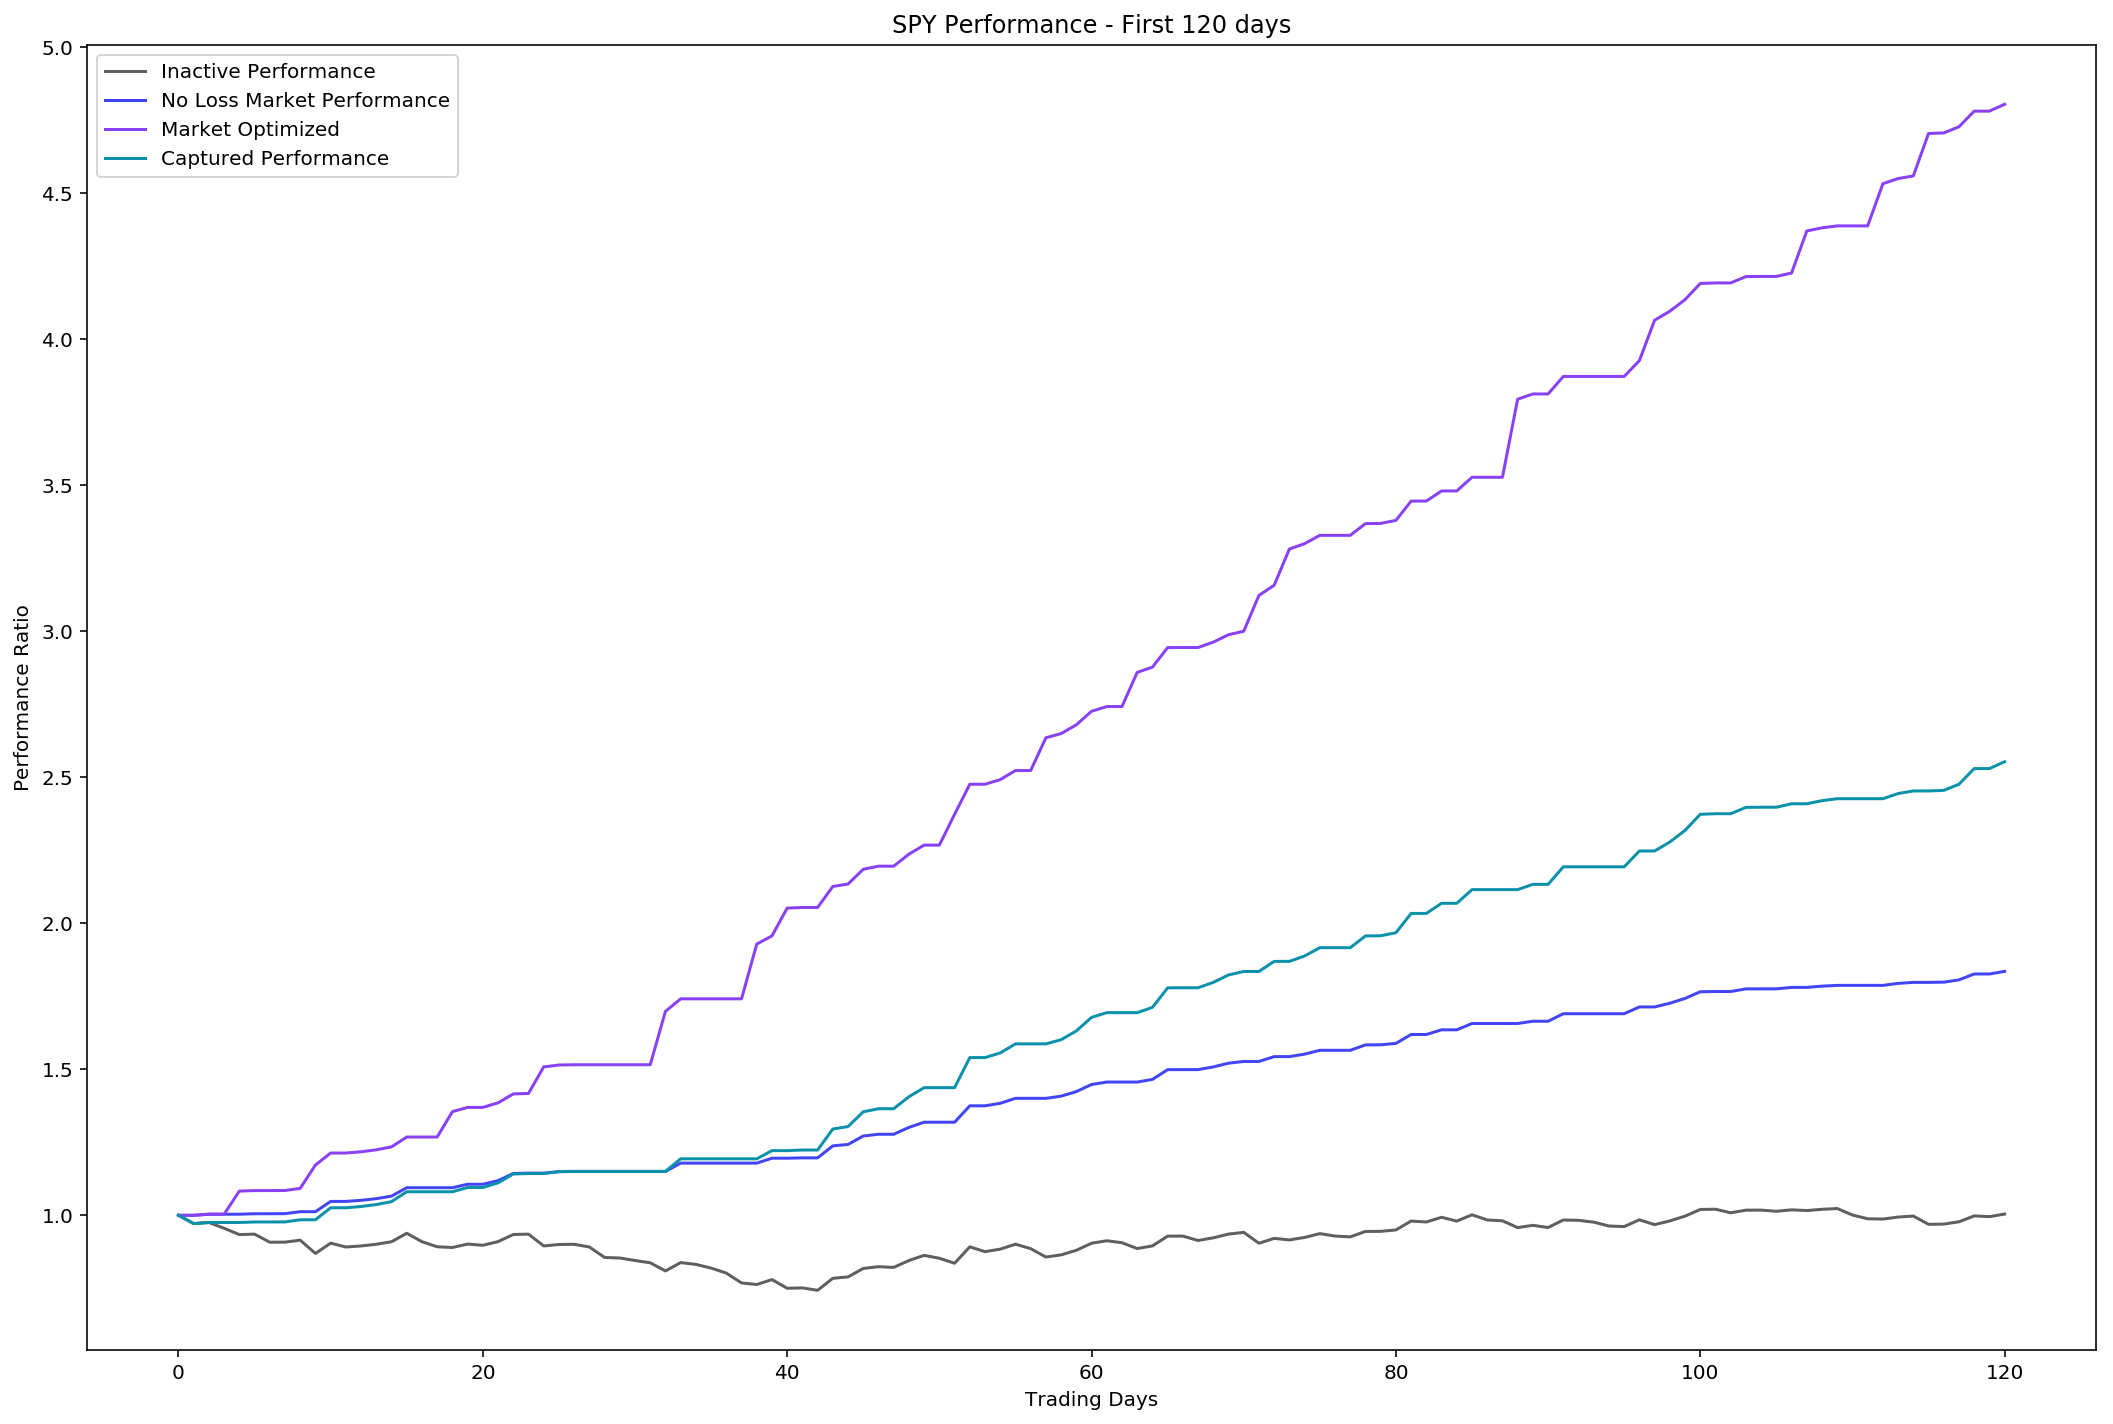

In [20]:
# Plot the performance metrics first 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Performance Ratio')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[:120,'InactivePerform'],'#5F5F5F', label='Inactive Performance')
plt.plot(trades_df.loc[:120,'NoLossMarketPerform'], '#4245f4', label='No Loss Market Performance')
plt.plot(trades_df.loc[:120,'MarketOptPerform'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[:120,'Performance'], '#0C91AB', label='Captured Performance')

# Set title
ax.set_title(base_ticker + ' Performance - First 120 days')
ax.legend(loc='upper left')

# Log of Results:
Lookback: 1 

Util Seq:

Test Score: 0.000007 MSE (0.002731 RMSE)

Delta Price: 0.001099 - RMSE * Adjusted Close Range

Basic Predict:

Test Score: 0.000019 MSE (0.004323 RMSE)

Delta Price: 0.002754 - RMSE * Adjusted Close Range


### SPY
Epochs: 1 Test Score: 0.000276 MSE (0.016620 RMSE)
Epochs: 50Test Score: 0.000171 MSE (0.013071 RMSE)

### GE
- Test Score: 0.00116 MSE (0.03407 RMSE)

### MSFT
- Test Score: 0.000031 MSE (0.005605 RMSE)

### AAPL
- Test Score: 0.001395 MSE (0.037350 RMSE)